Used ideas from 'Classification of Male and Female Speech Using Perceptual Features' DOI:10.1109/ICCCNT.2017.8204065

In [1]:
import os
from os.path import join
from os import listdir
import pandas as pd
import numpy as np
from itertools import product

import IPython.display as ipd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

from scipy.stats import skew

In [2]:
from typing import List, Tuple, Dict

In [3]:
import librosa

In [4]:
audio_path = 'data/dev-clean/'
SEED = 0

N_CHROMA = 88
N_FOURIER_COEF = 30
FRAME_LENGTH = 1024           # sampling rate is 22kHZ, so 1024/220000 is approx 50 ms (as in paper)
HOP_LENGTH = FRAME_LENGTH // 2
SEC_PER_WINDOW = 2

In [5]:
speakers = pd.read_csv('data/speakers.tsv', sep='\t').reset_index()
speakers.columns = ['READER', 'GENDER', 'SUBSET', 'NAME']
speakers.head()

,READER,GENDER,SUBSET,NAME
0,14,F,train-clean-360,Kristin LeMoine
1,16,F,train-clean-360,Alys AtteWater
2,17,M,train-clean-360,Gord Mackenzie
3,19,F,train-clean-100,Kara Shallenberg
4,20,F,train-other-500,Gesine


In [6]:
speakers_in_data = list(map(int, listdir(audio_path)))
len(speakers_in_data)

40

In [7]:
speakers = speakers.merge(pd.Series(speakers_in_data, name='READER'), on='READER')
speakers.set_index('READER', inplace=True)
speakers.head()

,GENDER,SUBSET,NAME
READER,,,
84,F,dev-clean,Christie Nowak
174,M,dev-clean,Peter Eastman
251,M,dev-clean,Mark Nelson
422,M,dev-clean,President Lethe
652,M,dev-clean,Scott Walter


In [8]:
with open('./data/CHAPTERS.txt', 'r') as f:
    raw_text = list(map(lambda x: x.strip('\n'), f.readlines()))

header_end = 0
for i, line in enumerate(raw_text):
    if not line.startswith(';'):
        header_end = i
        break
        
table = [map(str.strip, line.split('|')) for line in raw_text[header_end:]]
columns = list(map(lambda x: x.strip(';').strip(), raw_text[header_end-1].split('|')))
chapters_df = pd.DataFrame(table, columns=columns).astype(dtype={'ID':int, 'READER': int, 'MINUTES': float})
chapters_df.head()

,ID,READER,MINUTES,SUBSET,PROJ.,BOOK ID,CH. TITLE,PROJECT TITLE
0,1,110,19.77,train-other-500,53,1023,In Chancery,Bleak House
1,2,110,10.30,train-other-500,53,1023,In Fashion,Bleak House
2,159,4174,7.67,train-other-500,68,2184,Letter XXV,Unbeaten Tracks in Japan
3,198,19,8.42,train-clean-100,219,121,Chapter 01,Northanger Abbey
4,199,98,11.68,train-clean-360,219,121,Chapter 02,Northanger Abbey


In [9]:
speakers.merge(chapters_df, on='READER')[['GENDER', 'MINUTES']].groupby('GENDER').sum()

,MINUTES
GENDER,
F,161.47
M,161.80


In [10]:
dataset_list = []
for reader in listdir(audio_path):
    chapters_path = join(audio_path, reader)
    for chapter in listdir(chapters_path):
        files_path = join(chapters_path, chapter)
        for file in listdir(files_path):
            if file.endswith('.wav'):
                reader_gender = speakers.loc[int(reader)].GENDER
                dataset_list.append((int(reader), reader_gender, join(files_path, file)))
dataset_df = pd.DataFrame(dataset_list, columns=['reader', 'gender', 'path'])
dataset_df.head()

,reader,gender,path
0,1919,F,data/dev-clean/1919/142785/1919_142785_000005_...
1,1919,F,data/dev-clean/1919/142785/1919_142785_000118_...
2,1919,F,data/dev-clean/1919/142785/1919_142785_000035_...
3,1919,F,data/dev-clean/1919/142785/1919_142785_000064_...
4,1919,F,data/dev-clean/1919/142785/1919_142785_000071_...


In [11]:
dataset_df.groupby('gender').count()

,reader,path
gender,,
F,2976,2976
M,2760,2760


In [12]:
durations = dataset_df.path.apply(lambda x: librosa.get_duration(filename=x))
durations

0        9.820000
1        8.360000
2        6.410000
3       10.380000
4        1.489958
          ...    
5731     8.240000
5732     6.040000
5733     4.900000
5734     5.130000
5735     8.900000
Name: path, Length: 5736, dtype: float64

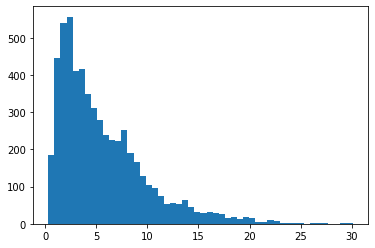

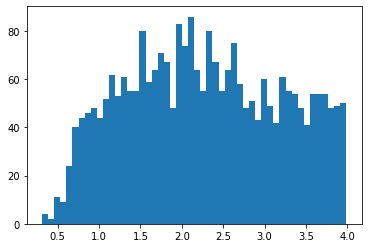

In [13]:
plt.hist(durations,bins=50);
plt.show()
plt.hist(durations[durations<4],bins=50);

In [14]:
len(dataset_df[durations>=SEC_PER_WINDOW])/len(dataset_df)

0.8131101813110181

In [15]:
dataset_df = dataset_df[durations>=SEC_PER_WINDOW]

In [16]:
def calc_abs_fouire_coefs(novelty_curve: np.ndarray, t: np.ndarray) -> np.ndarray:
    split_indxs = [0]+[np.where(np.floor(t)==(i+1)*SEC_PER_WINDOW)[0][0] for i in range(int(t[-1]//SEC_PER_WINDOW))]

    res = []
    for i in range(len(split_indxs)-1):
        res.append(np.abs(np.fft.fft(novelty_curve[split_indxs[i]:split_indxs[i+1]])[:N_FOURIER_COEF]))
    
    return np.array(res)

In [17]:
def calc_fourier_coefs_features(novelty_curve: np.ndarray, sr: int) -> np.ndarray:
    t = librosa.frames_to_time(range(len(novelty_curve)), sr, hop_length=HOP_LENGTH, n_fft=FRAME_LENGTH)
    
    coefs_by_windows = calc_abs_fouire_coefs(novelty_curve, t)
    coefs_mean = coefs_by_windows.mean(0)
    coefs_std = coefs_by_windows.std(0)

    return [coefs_mean, coefs_std]

In [18]:
def get_features(sample_path: str) ->np.ndarray:
    y, sr = librosa.load(sample_path)
    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=N_CHROMA, hop_length=HOP_LENGTH, n_fft=FRAME_LENGTH)
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP_LENGTH, frame_length=FRAME_LENGTH)
    rms = librosa.feature.rms(y, hop_length=HOP_LENGTH, frame_length=FRAME_LENGTH)
    novelty_curve = librosa.onset.onset_strength(y, sr=sr)
    skewness = skew(y)
    fourier_coefs_features = calc_fourier_coefs_features(novelty_curve, sr)
    
    features = [chroma_stft.mean(1)]
    for el in [zcr, rms, novelty_curve[None, :]]:
        features.append(el.mean(1))
        features.append(el.std(1))
    features.append(skewness)
    
    
    return np.hstack(features+fourier_coefs_features)

In [19]:
def process_batch(samples_paths: List[str]) -> Dict[str, np.ndarray]:
    res = {}
    for sample_path in samples_paths:
        res[sample_path] = get_features(sample_path)
    return res

In [20]:
features_name = [f'chroma_stft_{i}_{aggr}' for i, aggr in product(range(N_CHROMA), ['mean'])]
features_name += [f'{method}_{aggr}' for method, aggr in product(['zcr', 'rms', 'spectral_flux'],
                                                                 ['mean', 'std'])]
features_name.append('skewness_mean')
features_name += [f'fourier_{i}_{aggr}' for i, aggr in product(range(N_FOURIER_COEF), ['mean', 'std'])]
len(features_name)

155

In [21]:
n_jobs = 12
batch_size = 100
batch_number = int(np.ceil(len(dataset_df)/batch_size))
print(f'batch number: {batch_number}')
jobs = []
for i in range(batch_number):
    jobs.append(delayed(process_batch)(dataset_df.path[i*batch_size:(i+1)*batch_size].values))
features = Parallel(n_jobs=n_jobs, verbose=10)(jobs)

batch number: 47


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   21.8s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   30.5s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   52.0s
[Parallel(n_jobs=12)]: Done  29 out of  47 | elapsed:  1.3min remaining:   48.1s
[Parallel(n_jobs=12)]: Done  34 out of  47 | elapsed:  1.4min remaining:   31.5s
[Parallel(n_jobs=12)]: Done  39 out of  47 | elapsed:  1.7min remaining:   21.2s
[Parallel(n_jobs=12)]: Done  44 out of  47 | elapsed:  1.8min remaining:    7.3s
[Parallel(n_jobs=12)]: Done  47 out of  47 | elapsed:  1.8min finished


In [22]:
features_dict = {}
for el in features:
    for k,v in el.items():
        features_dict[k] = v
features_df = pd.DataFrame(features_dict).T
features_df.columns = features_name
features_df.index.name = 'path'
features_df.head()

,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,chroma_stft_7_mean,chroma_stft_8_mean,chroma_stft_9_mean,...,fourier_25_mean,fourier_25_std,fourier_26_mean,fourier_26_std,fourier_27_mean,fourier_27_std,fourier_28_mean,fourier_28_std,fourier_29_mean,fourier_29_std
path,,,,,,,,,,,,,,,,,,,,,
data/dev-clean/1919/142785/1919_142785_000005_000002.wav,0.257667,0.260941,0.260627,0.260974,0.264403,0.268702,0.265345,0.259730,0.259609,0.261992,...,7.247560,6.834326,11.152557,7.371055,2.139417,6.980699,6.690299,8.143005,5.156007,6.926347
data/dev-clean/1919/142785/1919_142785_000118_000001.wav,0.351155,0.339509,0.331138,0.324826,0.317682,0.311728,0.303800,0.296491,0.297595,0.300528,...,9.900573,6.351802,13.242432,8.743847,13.568657,9.211354,7.838845,2.233069,6.773000,7.983278
data/dev-clean/1919/142785/1919_142785_000035_000001.wav,0.216299,0.212288,0.216035,0.218830,0.221038,0.224242,0.225550,0.229322,0.233747,0.234828,...,4.503046,4.584075,5.707855,8.854382,4.414703,2.194819,3.986808,2.231112,11.456552,3.195519
data/dev-clean/1919/142785/1919_142785_000064_000003.wav,0.306730,0.291617,0.290036,0.291296,0.291558,0.287382,0.281830,0.282077,0.286006,0.288771,...,7.970376,12.983988,7.974744,7.372138,9.622538,8.023809,8.653289,2.348849,5.060957,6.579962
data/dev-clean/1919/142785/1919_142785_000059_000000.wav,0.264273,0.270635,0.257493,0.256361,0.259760,0.255054,0.249914,0.238382,0.228974,0.231650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
dataset = dataset_df.join(features_df, on='path')
dataset.gender = dataset.gender.apply(lambda x: int(x=='F'))
dataset.head()

,reader,gender,path,chroma_stft_0_mean,chroma_stft_1_mean,chroma_stft_2_mean,chroma_stft_3_mean,chroma_stft_4_mean,chroma_stft_5_mean,chroma_stft_6_mean,...,fourier_25_mean,fourier_25_std,fourier_26_mean,fourier_26_std,fourier_27_mean,fourier_27_std,fourier_28_mean,fourier_28_std,fourier_29_mean,fourier_29_std
0,1919,1,data/dev-clean/1919/142785/1919_142785_000005_...,0.257667,0.260941,0.260627,0.260974,0.264403,0.268702,0.265345,...,7.247560,6.834326,11.152557,7.371055,2.139417,6.980699,6.690299,8.143005,5.156007,6.926347
1,1919,1,data/dev-clean/1919/142785/1919_142785_000118_...,0.351155,0.339509,0.331138,0.324826,0.317682,0.311728,0.303800,...,9.900573,6.351802,13.242432,8.743847,13.568657,9.211354,7.838845,2.233069,6.773000,7.983278
2,1919,1,data/dev-clean/1919/142785/1919_142785_000035_...,0.216299,0.212288,0.216035,0.218830,0.221038,0.224242,0.225550,...,4.503046,4.584075,5.707855,8.854382,4.414703,2.194819,3.986808,2.231112,11.456552,3.195519
3,1919,1,data/dev-clean/1919/142785/1919_142785_000064_...,0.306730,0.291617,0.290036,0.291296,0.291558,0.287382,0.281830,...,7.970376,12.983988,7.974744,7.372138,9.622538,8.023809,8.653289,2.348849,5.060957,6.579962
5,1919,1,data/dev-clean/1919/142785/1919_142785_000059_...,0.264273,0.270635,0.257493,0.256361,0.259760,0.255054,0.249914,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
dataset.shape

(4664, 158)

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
pca = PCA(n_components=50, random_state=SEED)

In [26]:
first_feature_indx = dataset.columns.to_list().index('path') + 1

In [27]:
def calc_scores(clf, X, y):
    preds = clf.predict(X)
    return {
        'accuracy': np.round(accuracy_score(y, preds), 3),
        'f1': np.round(f1_score(y, preds), 3),
        'matthews': np.round(matthews_corrcoef(y, preds), 3)
    }

In [28]:
def cross_val(clf, use_pca):
    scores = {}
    for train_reader_indxs, test_reader_indxs in skf.split(speakers, speakers.GENDER):
        train_readers = set(speakers.iloc[train_reader_indxs].index.values)
        test_readers  = set(speakers.iloc[test_reader_indxs].index.values)

        train_dataset = dataset[[el in train_readers for el in dataset.reader]]
        test_dataset  = dataset[[el in test_readers  for el in dataset.reader]]

        X_train = train_dataset.iloc[:, first_feature_indx:].values
        y_train = train_dataset.gender.values

        X_test = test_dataset.iloc[:, first_feature_indx:].values
        y_test = test_dataset.gender.values
        
        if use_pca:
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        neigh = KNeighborsClassifier(n_neighbors=3)
        clf.fit(X_train, y_train)
        
        for score_name, score in calc_scores(clf, X_test, y_test).items():
            scores.setdefault(score_name, []).append(score)

    return scores, {score_name: np.round(np.mean(score),2) for score_name, score in scores.items()}


In [29]:
clf = SVC(gamma='scale', kernel='poly', degree=2, random_state=SEED)
_, mean_scores = cross_val(clf, use_pca=True)
print(mean_scores)

{'accuracy': 0.52, 'f1': 0.6, 'matthews': 0.07}


In [30]:
clf = SVC(gamma='scale', kernel='poly', degree=2, random_state=SEED)
_, mean_scores = cross_val(clf, use_pca=False)
print(mean_scores)

{'accuracy': 0.6, 'f1': 0.63, 'matthews': 0.22}


In [31]:
clf = SVC(gamma='scale', kernel='rbf', random_state=SEED)
_, mean_scores = cross_val(clf, use_pca=False)
print(mean_scores)

{'accuracy': 0.6, 'f1': 0.63, 'matthews': 0.23}


In [32]:
clf = KNeighborsClassifier(n_neighbors=3, p=2)
_, mean_scores = cross_val(clf, use_pca=True)
print(mean_scores)

{'accuracy': 0.57, 'f1': 0.6, 'matthews': 0.16}


In [33]:
clf = KNeighborsClassifier(n_neighbors=3, p=2)
_, mean_scores = cross_val(clf, use_pca=False)
print(mean_scores)

{'accuracy': 0.56, 'f1': 0.6, 'matthews': 0.15}


In [34]:
rf = RandomForestClassifier(random_state=SEED)
_, mean_scores = cross_val(rf, use_pca=True)
print(mean_scores)

{'accuracy': 0.6, 'f1': 0.61, 'matthews': 0.23}


In [35]:
rf = RandomForestClassifier(random_state=SEED)
_, mean_scores = cross_val(rf, use_pca=False)
print(mean_scores)

{'accuracy': 0.81, 'f1': 0.82, 'matthews': 0.64}


In [36]:
fi_args = np.argsort(rf.feature_importances_)[::-1]
[features_name[i] for i in fi_args]

['chroma_stft_68_mean',
 'chroma_stft_66_mean',
 'chroma_stft_69_mean',
 'chroma_stft_71_mean',
 'chroma_stft_67_mean',
 'chroma_stft_70_mean',
 'chroma_stft_74_mean',
 'chroma_stft_64_mean',
 'skewness_mean',
 'chroma_stft_72_mean',
 'chroma_stft_62_mean',
 'chroma_stft_65_mean',
 'chroma_stft_63_mean',
 'chroma_stft_75_mean',
 'zcr_std',
 'chroma_stft_60_mean',
 'chroma_stft_78_mean',
 'chroma_stft_83_mean',
 'chroma_stft_73_mean',
 'chroma_stft_85_mean',
 'rms_mean',
 'chroma_stft_76_mean',
 'chroma_stft_14_mean',
 'chroma_stft_77_mean',
 'chroma_stft_81_mean',
 'zcr_mean',
 'chroma_stft_80_mean',
 'chroma_stft_18_mean',
 'chroma_stft_45_mean',
 'chroma_stft_61_mean',
 'chroma_stft_17_mean',
 'chroma_stft_16_mean',
 'chroma_stft_42_mean',
 'spectral_flux_std',
 'chroma_stft_22_mean',
 'chroma_stft_54_mean',
 'chroma_stft_21_mean',
 'chroma_stft_79_mean',
 'chroma_stft_87_mean',
 'spectral_flux_mean',
 'chroma_stft_57_mean',
 'chroma_stft_19_mean',
 'fourier_0_mean',
 'fourier_0_std'